# Using Spectral Weights

This guide shows how to weigh Scans and spectra during averaging and how to find out what weights were used in the process.


## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

    filename = dysh_data()
    sdf = GBTFITSLoad()
    sdf.select()
    sb = sdf.getps()
    ta = sb.timeaverage()
    ta.baseline()
    ta.average()
    ta.plot()
    tsys_weight


## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for this example.
import numpy as np
import astropy.units as u
from dysh.spectra import tsys_weight
from dysh.spectra import average_spectra
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(test="getps")

13:06:09.958 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use 
[GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad) 
to load the data, and then its 
[summary](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad.summary) 
method to inspect its contents.

In [4]:
sdf = GBTFITSLoad(filename)
sdf.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


### Position Switched Calibration
We calibrate several scans at once for NGC5291.
This results in a 
[ScanBlock](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) 
with 4 scans, each with 11 integrations. 
The default weights are unity, with one weight value per integration.

In [5]:
pssb = sdf.getps(object='NGC5291', ifnum=0, plnum=1, fdnum=0)
print(f"Number of scans: {len(pssb)}, Number of integrations per scan: {[k.nint for k in pssb]}")
print(f"Scan weights: {pssb.weights}")

Number of scans: 4, Number of integrations per scan: [11, 11, 11, 11]
Scan weights: [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


## Applying weights when averaging Scans
When time averaging integrations and/or scans to create a final spectrum, you can choose from dysh's two options ('tsys' or None) or supply your own weight array.

### 1. System temperature weighting
The default for 
[timeaverage()](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock.timeaverage)
is 'tsys' which calculates and applies system temperature weighting to each integration: 

$$
w = t_{exp} \times \delta\nu/T_{sys}^2
$$

where $t_{exp}$ is the integration exposure time, $\delta\nu$ is the channel width, and $T_{sys}$ is the system temperature.
You can check what those weights will be with 
[tsys_weight](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.SpectralAverageMixin.tsys_weight). 

In [6]:
pssb.tsys_weight

array([array([20.02238592, 19.23775753, 19.89469281, 19.13748516, 19.43619207,
              19.24989036, 19.94781504, 19.81766121, 19.90398672, 19.86791497,
              19.1754635 ])                                                   ,
       array([18.94476267, 19.78439063, 19.85434244, 19.90054628, 19.95968097,
              19.08878802, 18.97575899, 18.5760123 , 19.76114768, 19.71441725,
              19.70968407])                                                   ,
       array([18.77161334, 19.62257845, 19.70200273, 19.68613794, 19.65882906,
              19.85660591, 19.57284449, 19.60902436, 18.74157248, 18.6538321 ,
              18.75593527])                                                   ,
       array([18.44256036, 18.36839774, 18.34613799, 18.39603826, 17.95338427,
              19.04965151, 19.09771163, 19.18475276, 19.09809603, 19.09126971,
              18.34217249])                                                   ],
      dtype=object)

(Note this is an array of arrays rather than a multidimensional array because different scans may have differing numbers of integrations).

[timeaverage()](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock.timeaverage) with the default arguments will use these weights.
The final spectral weight is the sum of all weights.

In the following lines of code we will time average the $4\times11$ integrations using the default weights ('tsys'), and then remove a baseline from the resulting time average. For the baseline removal we exclude ranges at the edges of the spectrum and where we know there's a signal. We end by plotting the time averged baseline subtracted spectrum, and printing the weights and statistics.

13:06:11.407 I 1370000000.0 Hz is below the minimum spectral axis 1374818364.0 Hz. Replacing.
13:06:11.407 I 1430000000.0 Hz is above the maximum spectral axis 1424816838.1210938 Hz. Replacing.
13:06:11.408 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1380000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1395000000.0 Hz, 1405000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1420000000.0 Hz, 1424816838.1210938 Hz) 
]


final weights=[847.9619254640447 847.9619254640447 847.9619254640447 ...
 847.9619254640447 847.9619254640447 847.9619254640447]


{'mean': <Quantity 0.00493475 K>,
 'median': <Quantity 0.00348282 K>,
 'rms': <Quantity 0.05926608 K>,
 'min': <Quantity -1.74795386 K>,
 'max': <Quantity 0.76657301 K>,
 'npt': 32768,
 'nan': 0}

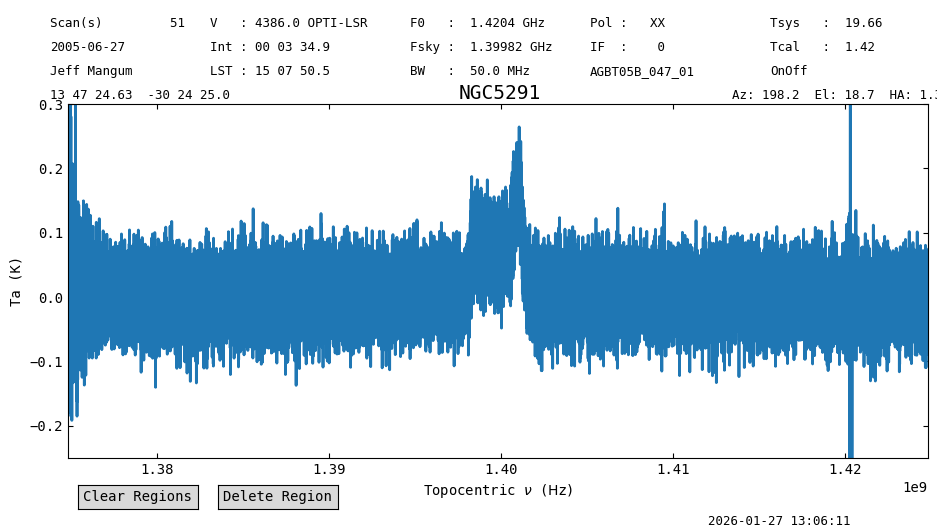

In [7]:
ta1 = pssb.timeaverage()  # default is weights='tsys'

# Define regions to be excluded from the baseline fit.
exclude_regions = [(1.37*u.GHz,1.38*u.GHz),
                   (1.395*u.GHz,1.405*u.GHz),
                   (1.42*u.GHz,1.43*u.GHz)]

# Fit an order 1 polynomial excluding the ranges defined above and subtract it (remove=True).
ta1.baseline(degree=1, remove=True, exclude=exclude_regions)

# Plot the result.
ta1.plot(ymin=-0.25, ymax=0.3)

# Print final weights and statistics.
print(f"final weights={ta1.weights}")
ta1.stats()  # rms 0.05926608 K

### 2. Equal weighting
Supplying `weights=None` will weight all integrations the same.
In this case, the result is not much different than `tsys`, because the $T_{sys}$ weights were already pretty uniform.
We also baseline subtract and plot the results.

13:06:12.352 I 1370000000.0 Hz is below the minimum spectral axis 1374818364.0 Hz. Replacing.
13:06:12.353 I 1430000000.0 Hz is above the maximum spectral axis 1424816838.1210938 Hz. Replacing.
13:06:12.354 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1380000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1395000000.0 Hz, 1405000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1420000000.0 Hz, 1424816838.1210938 Hz) 
]


final weights=[4.0 4.0 4.0 ... 4.0 4.0 4.0]


{'mean': <Quantity 0.00493513 K>,
 'median': <Quantity 0.00344473 K>,
 'rms': <Quantity 0.05928395 K>,
 'min': <Quantity -1.74943677 K>,
 'max': <Quantity 0.76626611 K>,
 'npt': 32768,
 'nan': 0}

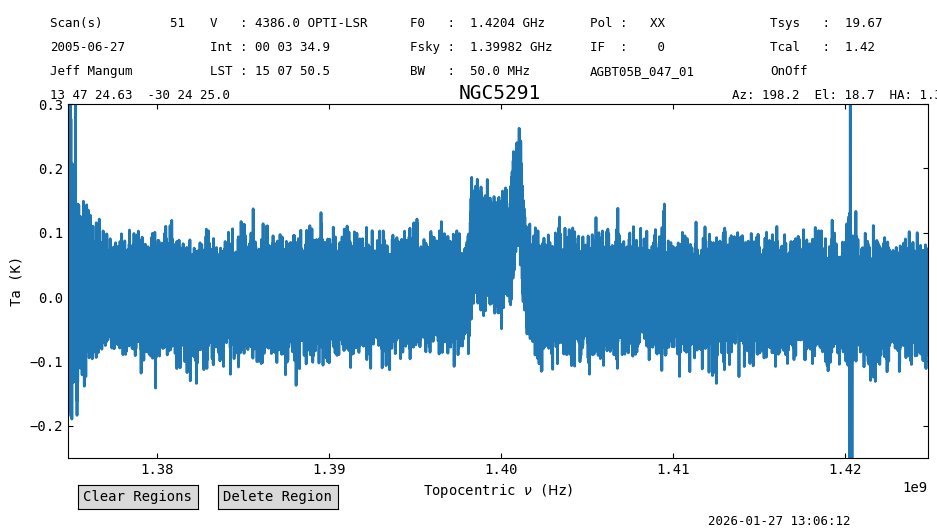

In [8]:
ta2 = pssb.timeaverage(weights=None)  
ta2.baseline(degree=1, remove=True, exclude=exclude_regions)
ta2.plot(ymin=-0.25, ymax=0.3)
print(f"final weights={ta2.weights}")
ta2.stats() # rms 0.05928395 K

### 3. User-supplied weights
You can supply a numpy array of weights to apply.  For 
[ScanBlock.timeaverage()](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock.timeaverage) 
the weights must have shape `(Nint,)` or `(Nint,nchan)` where `Nint` is the number of integrations in the 
[ScanBlock](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) 
and `nchan` is the number of channels in each scan.  

#### 3a.  Number of weights equal to number of integrations
We create a slightly silly example, that weights later integrations more.

13:06:13.093 I 1370000000.0 Hz is below the minimum spectral axis 1374818364.0 Hz. Replacing.
13:06:13.094 I 1430000000.0 Hz is above the maximum spectral axis 1424816838.1210938 Hz. Replacing.
13:06:13.094 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1380000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1395000000.0 Hz, 1405000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1420000000.0 Hz, 1424816838.1210938 Hz) 
]


final weights=[990.0 990.0 990.0 ... 990.0 990.0 990.0]


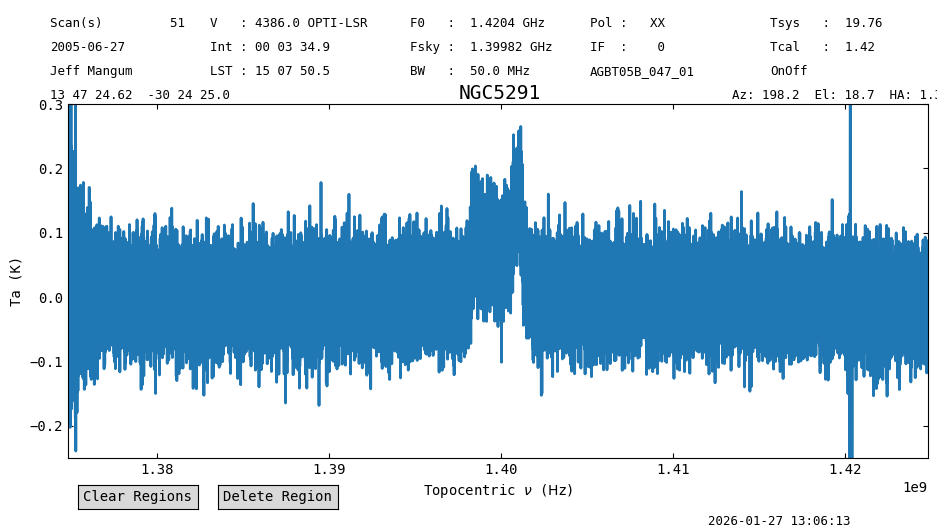

In [9]:
w = np.arange(1, pssb.nint+1, dtype=float)
ta3a = pssb.timeaverage(weights=w)
ta3a.baseline(degree=1, remove=True, exclude=exclude_regions)
ta3a.plot(ymin=-0.25, ymax=0.3)
print(f"final weights={ta3a.weights}")

#### 3b. Weights for each channel and integration
Supposed you had a channel-based $T_{sys}$ for each integration and wanted to calculate and apply system temperature weights. 
This can be accomplished by giving a weights array to 
[ScanBlock.timeaverage()](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock.timeaverage).

First we fake a `tsys` array of the correct shape.
Then we calculate system temperate weights using the mean exposure time and mean channel width of the scans.

In [10]:
np.random.seed(123)  # make sure we have a fixed seed
tsys = 30 + np.random.rand(pssb.nint, pssb.nchan)*15.0  # Fake system temperature array in the 30-45K range.
# The mean exposure and channel width.
dt = np.mean(np.mean(pssb.exposure))
df = np.mean(np.mean(pssb.delta_freq))

# Compute new weights using the inverse variance as given by the radiometer equation.
w = tsys_weight(dt, df, tsys)
print(f"{tsys=}")
print(f"Weights array shape: {w.shape}")

tsys=array([[40.44703778, 34.29209002, 33.4027718 , ..., 38.71791603,
        35.28713315, 40.87063212],
       [38.05088391, 33.34662369, 42.20490842, ..., 41.80063624,
        38.89300609, 40.57733459],
       [35.43088049, 39.82836535, 33.14689888, ..., 33.44782766,
        40.81104733, 34.50116723],
       ...,
       [44.27286605, 40.55077356, 32.97672831, ..., 40.44991244,
        31.97284355, 39.87806732],
       [43.54054032, 37.95174176, 36.0192332 , ..., 30.24616871,
        32.32690178, 40.55712875],
       [31.4013107 , 36.35880619, 38.0259688 , ..., 34.22566874,
        42.53679606, 40.73033967]])
Weights array shape: (44, 32768)


Now time average the data using the weights defined above, and repeat the baseline subtraction and plotting.

13:06:13.849 I 1370000000.0 Hz is below the minimum spectral axis 1374818364.0 Hz. Replacing.
13:06:13.850 I 1430000000.0 Hz is above the maximum spectral axis 1424816838.1210938 Hz. Replacing.
13:06:13.850 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1380000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1395000000.0 Hz, 1405000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (1420000000.0 Hz, 1424816838.1210938 Hz) 
]


final weights=[243.4369815211293 245.3675937036399 237.113209395157 ...
 242.40007314462267 249.6812817163117 237.80401320732614]


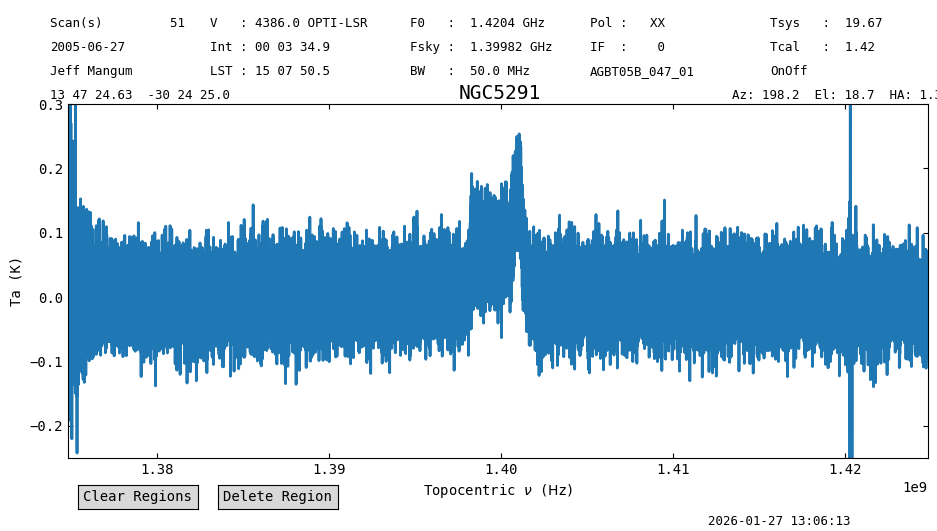

In [11]:
ta3b = pssb.timeaverage(weights=w)
ta3b.baseline(degree=1, remove=True, exclude=exclude_regions)
ta3b.plot(ymin=-0.25, ymax=0.3)
print(f"final weights={ta3b.weights}")

Note the scan weights have been updated, and are now equal to the weights supplied to the `timeaverage` function, so their shape  is now (nint, nchan).

In [12]:
print(pssb[0].weights.shape)
print(f"Are the Scan weights the same as those we defined? {np.all(w[0:11] == pssb[0].weights)}")

(11, 32768)
Are the Scan weights the same as those we defined? True


## Applying weights when averaging Spectrum
The method 
[average_spectra](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.average_spectra) 
can compute weighted averages in 3 ways.
The first two are the usual `weights='tsys'` and `weights=None` options.
The third option, `weights='spectral'` will average the spectra using the values in each of their `weights` array.
Note that 
[average_spectra](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.average_spectra)
is the function used by 
[Spectrum.average](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.average)
to average spectra.

In [13]:
sp = average_spectra([ta1, ta2, ta3a, ta3b], weights='spectral')

# but this is the same:
# sp = ta1.average([ ta2, ta3a, ta3b], weights='spectral')

final weights=[2085.398906985174 2087.329519167685 2079.0751348592016 ...
 2084.3619986086674 2091.6432071803565 2079.765938671371]


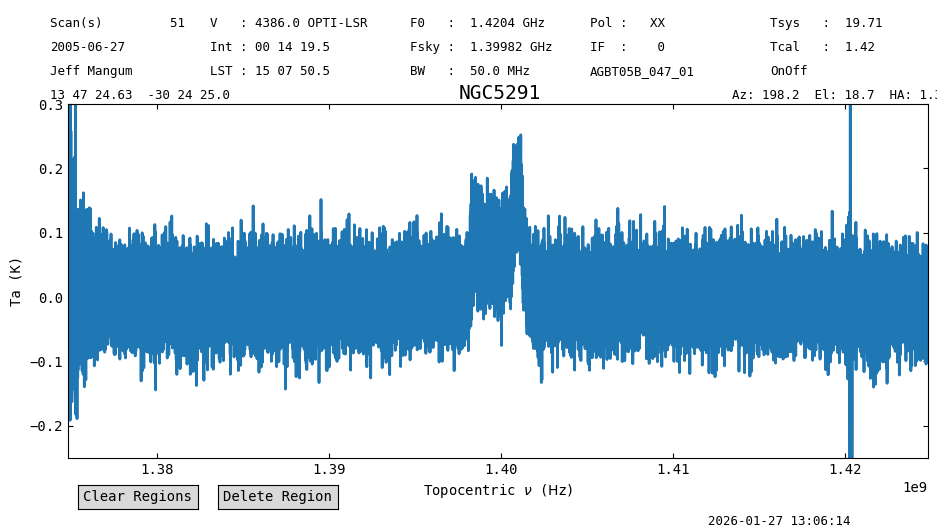

In [14]:
sp.plot(ymin=-0.25, ymax=0.3)
print(f"final weights={sp.weights}")

## Final Stats
Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.

In [15]:
sp.stats()  # rms 0.06025871 K

{'mean': <Quantity 0.00486611 K>,
 'median': <Quantity 0.00343484 K>,
 'rms': <Quantity 0.06025871 K>,
 'min': <Quantity -1.76988615 K>,
 'max': <Quantity 0.76265972 K>,
 'npt': 32768,
 'nan': 0}